In [14]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [15]:
class SegregationAgent(Agent):
    def __init__(self, unique_id, model, a_type, threshold):
        super().__init__(unique_id, model)
        self.type = a_type
        self.threshold = threshold
        
    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        same_type = 0   
        total_neighbors = 0
        fraction = 0
        for neighbor in neighbors:
            if self.type == neighbor.type:
                same_type += 1
            total_neighbors +=1
        if total_neighbors != 0:
            fraction = same_type / total_neighbors
        
        if fraction < self.threshold:
            self.model.grid.move_to_empty(self)

In [16]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (content, (x,y)) in model.grid.coord_iter():
        if content == None:
            grid[x][y] = 0
        else:
            grid[x][y] = content.type
    return grid

In [17]:
class SegregationModel(Model):
    """ Define nuestro modelo, los agentes y su entorno."""
    def __init__(self, width, height, diff_types = 2, threshold = .30, empty_cells = .20):
        self.num_agents = int( (width * height) * (1 - empty_cells) )
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        # Aquí definimos el recolector para obtener el grid completo.
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
        id = 0
        num_agents = int ((width * height)* (1 - empty_cells)) // diff_types
        amount =  num_agents // diff_types
        for i in range(1, (diff_types + 1)):
            for j in range(amount):
                a = SegregationAgent(id, self, i, threshold)
                self.grid.move_to_empty(a)
                self.schedule.add(a)
                id = id + 1
    
    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()

In [18]:
WIDTH = 30
HEIGHT = 30
THRESHOLD = 0.60
TYPES = 3
EMPTY_CELLS = 0.20

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 60

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
model = SegregationModel(WIDTH, HEIGHT, TYPES, THRESHOLD, EMPTY_CELLS)
for i in range(MAX_GENERATIONS):
    model.step()
    
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Tiempo de ejecución: 0:00:00.162741


In [19]:
all_grids = model.datacollector.get_model_vars_dataframe()

/var/folders/tz/r37k9_3148d0bw4yyhbjpj0c0000gn/T/ipykernel_24740/2666722068.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grids.iloc[0][0], cmap=plt.cm.binary)
/var/folders/tz/r37k9_3148d0bw4yyhbjpj0c0000gn/T/ipykernel_24740/2666722068.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grids.iloc[frame][0])


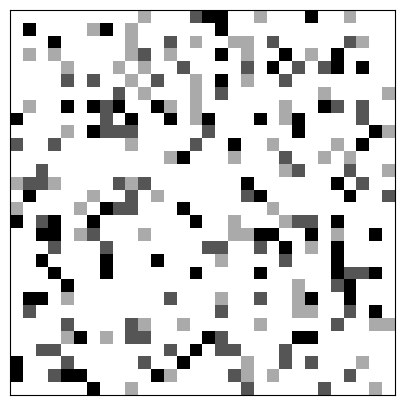

In [20]:
fig, axis = plt.subplots(figsize=(5,5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0][0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(all_grids.iloc[frame][0])
    
anim = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

In [21]:
anim

/var/folders/tz/r37k9_3148d0bw4yyhbjpj0c0000gn/T/ipykernel_24740/2666722068.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grids.iloc[frame][0])
